In [263]:
import numpy as np
from numpy import random
import math
from matplotlib import pyplot as plt
from scipy import misc
import scipy
from tqdm import tqdm, trange
from time import perf_counter

In [264]:
%cd ..
from rputil import *
%cd -

/mnt/c/Users/rishi/GitHub/icerm/random-projections
/mnt/c/Users/rishi/GitHub/icerm/random-projections/notebooks


## ID2, RID2

In [265]:
import scipy.linalg.interpolative as sli

def id2_rank_k(A, k):
    idx, proj = sli.interp_decomp(A, k, rand=False)
    B = sli.reconstruct_skel_matrix(A, k, idx)
    C = sli.reconstruct_matrix_from_id(B, idx, proj)
    return C

def rid2_rank_k(A, k):
    idx, proj = sli.interp_decomp(A, k, rand=True)
    B = sli.reconstruct_skel_matrix(A, k, idx)
    C = sli.reconstruct_matrix_from_id(B, idx, proj)
    return C

In [266]:
def rid3_rank_k(A, k, choices=None):
    cols = choices
    if choices is None:
        cols = np.random.choice(A.shape[1], replace=False, size=k)
    AS = A[:,cols]
    Q, R = scipy.linalg.qr(AS, pivoting=False, mode='economic')
    return Q @ Q.T @ A

In [267]:
def normalrandomprojid(A, k):
    Omega = np.random.randn(A.shape[1], k) #(n,k)
    Y = A @ Omega # (m,k)
    Q, R, P = scipy.linalg.qr(Y, mode='economic', pivoting=True)
    return Q @ (Q.T @ A) # parentheses are necessary for optimal performance

## Calculating Statistics

Here, we vary the rank k of the approximation and analyze the quality of the resulting compressed images:

In [268]:
import pandas as pd
mnist = pd.read_csv('../datasets/mnist/train.csv')

data = mnist[mnist.columns[1:]].values / 255
data = data[:5000]

Transpose the data matrix if necessary --- we want the matrix to be 'wide' not 'tall'.

In [269]:
data = data.T

In [270]:
data.shape

(784, 5000)

In [271]:
def display_img(A, n):
    choices = np.random.choice(A.shape[1], replace=False, size=n)
    plt.imshow(A[:,choices].reshape(28,28,n).transpose(0,2,1).reshape(28,n*28))

In [272]:
# array.shape = (a,b,c)
# np.transpose(array, (2,0,1)) = (c,a,b)

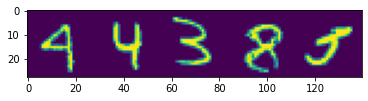

In [273]:
display_img(data, 5)

In [274]:
data_norm = np.linalg.norm(data)

In [275]:
def calculate_error(A):
    return np.linalg.norm(data - A) / data_norm

In [276]:
def stats(A):
    res = np.empty(7)
    
    res[0] = np.quantile(A, 0.25)
    res[1] = np.median(A)
    res[2] = np.quantile(A, 0.75)
    res[3] = np.mean(A)
    res[4] = np.std(A)
    res[5] = np.min(A)
    res[6] = np.max(A)
    
    return np.copy(res)

In [277]:
k_domain = np.concatenate(([1, 2, 5, 10], np.arange(20, 400, step=40), [400, 420, 440]))
k_len = k_domain.shape[0]

### deterministic methods

In [278]:
error_svd = np.empty(k_len)
error_id = np.empty(k_len)
error_id2 = np.empty(k_len)

time_svd = np.empty(k_len)
time_id = np.empty(k_len)
time_id2 = np.empty(k_len)

for i,val in enumerate(tqdm(k_domain)):
    #SVD
    start = perf_counter()
    error_svd[i] = calculate_error(svd_rank_k(data, val))
    time_svd[i] = perf_counter() - start
    
    #ID
    start = perf_counter()
    error_id[i] = calculate_error(id_rank_k(data, val))
    time_id[i] = perf_counter() - start
    
    #ID2 (SciPy)
    start = perf_counter()
    error_id2[i] = calculate_error(id2_rank_k(data, val))
    time_id2[i] = perf_counter() - start

100%|██████████| 17/17 [01:33<00:00,  5.48s/it]


### randomized methods

In [279]:
stat_dims = (7, k_len)
error_random_svd = np.empty(stat_dims)
error_random_id = np.empty(stat_dims)
error_random_id2 = np.empty(stat_dims)
error_random_id3 = np.empty(stat_dims)
error_nrpid = np.empty(stat_dims)

time_random_svd = np.empty(k_len)
time_random_id = np.empty(k_len)
time_random_id2 = np.empty(k_len)
time_random_id3 = np.empty(k_len)
time_nrpid = np.empty(k_len)

iterations = 3 #10

for i,val in enumerate(tqdm(k_domain)):
    err_rsvd = np.empty(iterations)
    err_rid = np.empty(iterations)
    err_rid2 = np.empty(iterations)
    err_rid3 = np.empty(iterations)
    err_nrpid = np.empty(iterations)
    
    t_rsvd = np.empty(iterations)
    t_rid = np.empty(iterations)
    t_rid2 = np.empty(iterations)
    t_rid3 = np.empty(iterations)
    t_nrpid = np.empty(iterations)
    
    for j in range(iterations):
        #RSVD
        start = perf_counter()
        err_rsvd[j] = calculate_error(random_svd_rank_k(data,val))
        t_rsvd[j] = perf_counter() - start
        
        #RID
        start = perf_counter()
        err_rid[j] = calculate_error(random_id_rank_k(data,val))
        t_rid[j] = perf_counter() - start
        
        #RID2 (SciPy)
        start = perf_counter()
        err_rid2[j] = calculate_error(rid2_rank_k(data,val))
        t_rid2[j] = perf_counter() - start
        
        #RID3 (no oversampling + no pivoting)
        start = perf_counter()
        err_rid3[j] = calculate_error(rid3_rank_k(data,val))
        t_rid3[j] = perf_counter() - start
        
        #Normal RP ID
        start = perf_counter()
        err_nrpid[j] = calculate_error(normalrandomprojid(data, val))
        t_nrpid[j] = perf_counter() - start
        
    
    error_random_svd[:,i] = stats(err_rsvd)
    error_random_id[:,i] = stats(err_rid)
    error_random_id2[:,i] = stats(err_rid2)
    error_random_id3[:,i] = stats(err_rid3)
    error_nrpid[:,i] = stats(err_nrpid)

    time_random_svd[i] = np.mean(t_rsvd)
    time_random_id[i] = np.mean(t_rid)
    time_random_id2[i] = np.mean(t_rid2)
    time_random_id3[i] = np.mean(t_rid3)
    time_nrpid[i] = np.mean(t_nrpid)

100%|██████████| 17/17 [01:49<00:00,  6.42s/it]


## Display results

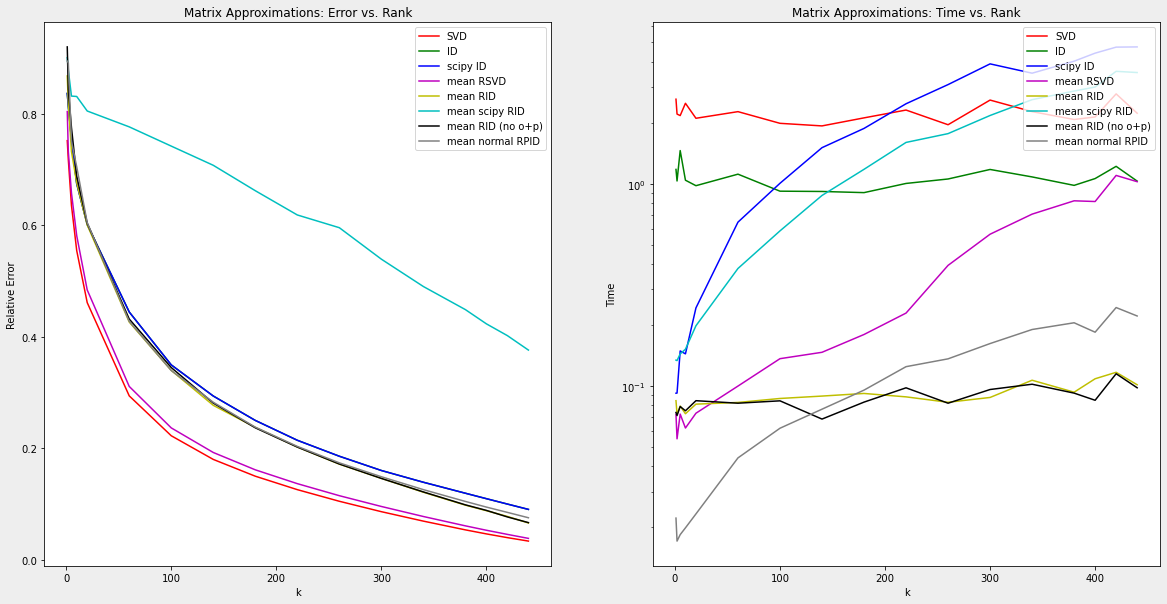

In [280]:
fig, ax = plt.subplots(1,2, figsize=(20,10))
fig.set_facecolor('#EEE')


ax[0].plot(k_domain, error_svd, c='r', label='SVD')
ax[0].plot(k_domain, error_id, c='g', label='ID')
ax[0].plot(k_domain, error_id2, c='b', label='scipy ID')
ax[0].plot(k_domain, error_random_svd[3], c='m', label='mean RSVD')
ax[0].plot(k_domain, error_random_id[3], c='y', label='mean RID')
ax[0].plot(k_domain, error_random_id2[3], c='c', label='mean scipy RID')
ax[0].plot(k_domain, error_random_id3[3], c='black', label='mean RID (no o+p)')
ax[0].plot(k_domain, error_nrpid[3], c='grey', label='mean normal RPID')
ax[0].set_xlabel('k')
ax[0].set_ylabel('Relative Error')
# ax[0].set_yscale('log')
ax[0].legend(loc='upper right')
ax[0].set_title('Matrix Approximations: Error vs. Rank')

ax[1].plot(k_domain, time_svd, c='r', label='SVD')
ax[1].plot(k_domain, time_id, c='g', label='ID')
ax[1].plot(k_domain, time_id2, c='b', label='scipy ID')
ax[1].plot(k_domain, time_random_svd, c='m', label='mean RSVD')
ax[1].plot(k_domain, time_random_id, c='y', label='mean RID')
ax[1].plot(k_domain, time_random_id2, c='c', label='mean scipy RID')
ax[1].plot(k_domain, time_random_id3, c='black', label='mean RID (no o+p)')
ax[1].plot(k_domain, time_nrpid, c='grey', label='mean normal RPID')
ax[1].set_xlabel('k')
ax[1].set_ylabel('Time')
ax[1].set_yscale('log')
ax[1].legend(loc='upper right')
ax[1].set_title('Matrix Approximations: Time vs. Rank');

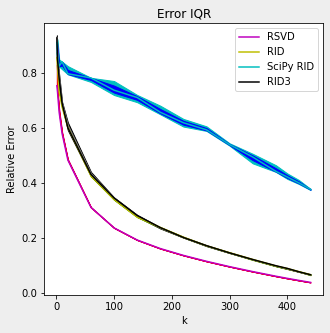

In [295]:
fig, ax = plt.subplots(1, figsize=(5,5))
fig.set_facecolor('#EEE')

ax.fill_between(k_domain, error_random_svd[5], error_random_svd[6], color='m')
ax.fill_between(k_domain, error_random_id[5], error_random_id[6], color='y')
ax.fill_between(k_domain, error_random_id2[5], error_random_id2[6], color='c')
ax.fill_between(k_domain, error_random_id3[5], error_random_id3[6], color='black')

ax.fill_between(k_domain, error_random_svd[0], error_random_svd[2], color='r')
ax.fill_between(k_domain, error_random_id[0], error_random_id[2], color='g')
ax.fill_between(k_domain, error_random_id2[0], error_random_id2[2], color='b')
ax.fill_between(k_domain, error_random_id3[0], error_random_id3[2], color='grey')

ax.plot(k_domain, error_random_svd[1], c='m', label='RSVD')
ax.plot(k_domain, error_random_id[1], c='y', label='RID')
ax.plot(k_domain, error_random_id2[1], c='c', label='SciPy RID')
ax.plot(k_domain, error_random_id3[1], c='black', label='RID3')

ax.set_xlabel('k')
ax.set_ylabel('Relative Error')
ax.legend(loc='upper right')
ax.set_title('Error IQR');

### Test to see if low-rank approximation preserves $k$ columns.

In [282]:
temp_k = 200

In [283]:
func = rid3_rank_k

In [284]:
cols = np.random.choice(data.shape[1], replace=False, size=temp_k)
approx = func(data, temp_k, choices=cols)

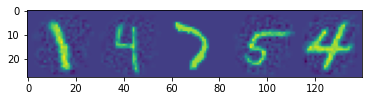

In [285]:
display_img(approx, 5)

In [286]:
eps = 0.00000001

print(f'{np.sum(approx > eps) / approx.size:.1%} of entries are greater than {eps}')

45.0% of entries are greater than 1e-08


In [287]:
print(f'The average value of an entry is {np.mean(approx):.4f}')

The average value of an entry is 0.1312


In [288]:
assert np.allclose(approx[:,cols], data[:,cols]), "This low-rank approximation was not formed from an ID."

In [289]:
np.linalg.matrix_rank(approx, tol=0.001)

200

In [290]:
np.linalg.matrix_rank(data, tol=0.001)

646

### Try to recreate the decomposition from the approximation.

In [291]:
C = approx[:,cols]

In [296]:
res = np.linalg.lstsq(C, approx, rcond=None)
Z = res[0]
print(f'Worst LS residual: {max(res[1])}')

Worst LS residual: 1.0093895259063744e-28


In [300]:
np.allclose(C @ Z, approx)

True

In [298]:
np.max(np.abs(Z))

1.0000000000000042